<a href="https://colab.research.google.com/github/gytj2013/NewPhago/blob/main/newphago_summarize.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!curl -s https://raw.githubusercontent.com/teddylee777/machine-learning/master/99-Misc/01-Colab/mecab-colab.sh | bash

In [ ]:
!pip install konlpy
!pip install git+https://github.com/kakaobrain/pororo.git
!pip install pykrx 
!pip install jamo

In [ ]:
! git clone https://github.com/SOMJANG/Mecab-ko-for-Google-Colab.git

In [ ]:
cd Mecab-ko-for-Google-Colab

In [ ]:
#!bash install_mecab-ko_on_colab_light_220111.sh
!bash install_mecab-ko_on_colab_light_220429.sh

In [6]:
from pororo import Pororo

In [ ]:
cd ../

In [ ]:
!pip install -U Finance-DataReader

In [15]:
# 코스피 코스닥 상장 기업 정보 리스트 생성
from pykrx import stock
import pandas as pd
import FinanceDataReader as fdr
import matplotlib.pyplot as plt
import platform
from datetime import datetime, timedelta

today = datetime.today().strftime("%Y%m%d")
last_week = (datetime.today() - timedelta(7)).strftime("%Y%m%d")

KOSDAQ = stock.get_market_ticker_list(market="KOSDAQ")
KOSPI = stock.get_market_ticker_list(market="KOSPI")

def return_name():
    Company = []

    for ticker in KOSDAQ:
        Value =stock.get_market_ticker_name(ticker)
        Company.append([Value,ticker,"KOSDAQ"]) # 기업명, 종목번호, 코스닥 리스트에 추가
      
    for ticker in KOSPI:
        Value =stock.get_market_ticker_name(ticker)
        Company.append([Value,ticker,"KOSPI"]) # 기업명, 종목번호, 코스닥 리스트에 추가
 
    return Company;

In [10]:
# 종성 여부 체크
from jamo import h2j, j2hcj

def get_jongsung_TF(text):
  sample_text_list = list(text)
  last_word = sample_text_list[-1]
  last_word_jamo_list = list(j2hcj(h2j(last_word)))
  last_jamo = last_word_jamo_list[-1]

  jongsung_TF = "T"

  if last_jamo in ['ㅏ','ㅑ','ㅓ','ㅕ','ㅗ','ㅛ','ㅜ','ㅠ','ㅡ','ㅣ','ㅘ','ㅚ','ㅙ','ㅝ','ㅞ','ㅢ','ㅐ','ㅔ','ㅟ','ㅖ','ㅒ'] :
    jongsung_TF = "F"

  return jongsung_TF

In [11]:
# 사용자 사전 적용 : 고유명사 구분하기 위해 코스피, 코스닥 상장 기업들 사용자 사전에 추가
with open("./mecab-ko-dic-2.1.1-20180720/user-dic/nnp.csv",'r',encoding='utf-8') as f:
  file_data = f.readlines()
Company = return_name()
for c in Company:
  jongsung_TF = get_jongsung_TF(c[0])
  line = '{},,,,NNP,*,{},{},*,*,*,*,*\n'.format(c[0], jongsung_TF, c[0])
  file_data.append(line)
with open("./mecab-ko-dic-2.1.1-20180720/user-dic/nnp.csv",'w',encoding='utf-8') as f:
  for line in file_data:
    f.write(line)

In [12]:
# 뉴스 요약 및 기업 정보 추출
from bs4 import BeautifulSoup
import requests
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize
from konlpy.tag import Mecab
from pykrx import stock
import pandas as pd
import FinanceDataReader as fdr
import matplotlib.pyplot as plt
import platform
from datetime import datetime, timedelta

today = datetime.today().strftime("%Y%m%d")
last_week = (datetime.today() - timedelta(7)).strftime("%Y%m%d")

bullet_summ = Pororo(task="text_summarization", lang="ko", model="bullet")
abs_summ = Pororo(task="text_summarization", lang="ko", model="abstractive")
# 감성 분석
stock_feel=Pororo(task='sentiment', model='brainbert.base.ko.nsmc', lang='ko')

def summerize_news(url, Company):
    headers = {"User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/87.0.4280.88 Safari/537.36"}
    req = requests.get(url, headers=headers)
    soup = BeautifulSoup(req.text, 'html.parser')
    body = soup.find_all(id='dic_area')
    if len(body) > 0:
        text = body[0].text
        output_bullet = bullet_summ(text,
                                    beam=5,
                                    len_penalty=0.6,
                                    no_repeat_ngram_size=3,
                                    top_k=50,
                                    top_p=0.7)
        summary_output = abs_summ(text,
                                  beam=5,
                                  len_penalty=0.6,
                                  no_repeat_ngram_size=3,
                                  top_k=50,
                                  top_p=0.7
                                  )
      
        mecab = Mecab()
        noun = mecab.nouns(summary_output) # 명사만 추출
        pos = mecab.pos(summary_output) # 형태소 분석
        removelist = ['JKS', 'JKC', 'JKG', 'JKO', 'JKB', 'JKV', 'JKQ', 'JX', 'JC', 'EF'] # 조사 품사 리스트 - 제거할 품사
        resultlist = []
        for p in pos :
          if len(p[0])>1 and p[1] not in removelist : # 토큰의 길이가 1 초과이고 조사가 아니면 감정 분석에 활용할 토큰이므로 리스트에 추가
            resultlist.append(p)
        #print(pos)
        #print(resultlist)

        company_name = []
        for c in Company :
          company_name.append(c[0]);

        summ = "[주요] \n"
        for line in output_bullet:
          summ += "-"+line+"\n"
        summ += "[요약] \n"
        summ += summary_output+"\n" # 뉴스 요약본
        summ += "[회사정보] \n"
        chk = False
        idx = 0
        for n in noun : # 뉴스 요약본 속 명사들 중에서 코스피, 코스닥 상장 기업명 찾기
          try :
            idx = company_name.index(n)
          except :
            chk = False
          else :
            summ += str(Company[idx])
            chk = True
            break
        if chk==False :
          summ += "null \n"
        feel_res=stock_feel(summary_output)
        print(feel_res)
        print(summ)
        if (idx != 0):
          ticker = Company[idx][1]
          info_a = stock.get_market_ohlcv(last_week, today, ticker)
          print(info_a) #주가
          info_b = stock.get_market_cap(last_week, today, ticker)
          print(info_b) #시가총액, 거래량, 거래대금, 상장주식수 
          info_c = stock.get_exhaustion_rates_of_foreign_investment(last_week, today, ticker)
          print(info_c) #외국인 보유량 및 외국인 한도소진율
          info_d = stock.get_market_fundamental(last_week, today, ticker)
          print(info_d) #DIV/BPS/PER/EPS
          info_e = stock.get_shorting_volume_by_date(last_week, today, ticker)
          print(info_e) #공매도 현황
          info_g = fdr.DataReader(symbol=ticker, start= "2020")
          fig = plt.figure(figsize=(14, 6))
          ax = fig.add_subplot(1, 1, 1)
          ax.plot(info_g['Close'])
          ax.set_xlabel("Date")
          ax.set_ylabel(ticker)
          ax.set_title("stock price")
          plt.grid(True, axis='y')
          plt.show() #주가그래프
        return summ
    else:
        print("error")
        return "error"

Downloading:   0%|          | 0.00/1.35k [00:00<?, ?B/s]

You passed along `num_labels=3` with an incompatible id to label map: {'0': 'NEGATIVE', '1': 'POSITIVE'}. The number of labels wil be overwritten to 2.


Downloading:   0%|          | 0.00/337 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.00M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/110 [00:00<?, ?B/s]




You passed along `num_labels=3` with an incompatible id to label map: {'0': 'NEGATIVE', '1': 'POSITIVE'}. The number of labels wil be overwritten to 2.



Negative
[주요] 
-금융위, 퇴직연금감독규정 개정 예고
- 디폴트옵션 투자 한도 100%로
[요약] 
금융금융위원회는 퇴직연금 계좌에서 디폴트옵션 상품의 투자 한도를 100%로 정하는 내용의 퇴직연금감독규정 개정안을 16일 예고하여 투자 한도가 높아지면 예금이나 채권형 펀드처럼 투자 비중을 100%까지 높여 계좌 운용이 가능하다.
[회사정보] 
null 

Negative
[주요] 
-1분기 영업익 206억...전년比 85.3%↓
- "기준금리 인상으로 시장 거래대금 감소"
[요약] 
유안타증권의 연결 재무제표 기준 올해 1분기 영업이익이 지난해보다 85.3% 줄었는데, 이는 지난해 동기 대비 85.3% 줄어든 것이다.
[회사정보] 
null 

Negative
[주요] 
-현대차그룹·산업은행 등 탄탄한 투자자 확보
- 1000억 디지털산업 혁신펀드 결성 완료
[요약] 
신영증권이 앞서 크래프톤과 직방 등에 투자하며 결실을 맺은 것이 투자자 유치에 한 몫해 1000억원의 디지털산업 혁신펀드 결성을 완료했다.
[회사정보] 
null 

Positive
[주요] 
-탈모 예방에 도움...탈모 예방에도 도움
- 체중 감량을 목표로 하는 사람이라면 오이에 대해 다시 한번 생각하는 것도 좋을 듯
[요약] 
맛가루 대신 오이를 활용한 요리법을 소개하며, 오이물에 함유된 카로틴이 암세포 발생을 억제하는 항산화 작용을 하기 때문에 체중 감량에 도움이 된다고 말했다.
[회사정보] 
null 

Negative
[주요] 
-"권 대표 공식사과하고 보상 계획 말해야"
- "투자 실패에 따른 극단적 선택 암시"
[요약] 
' '도쿄 코인'을 발행한 테라폼랩스 권도형 대표의 집에서 초인종을 눌렀던 남성이 경찰에 조사를 받자 '권 대표가 공식 사죄하고 가진 자금을 동원하든 어떠한 (보상) 계획을 말해야 한다'고 말했다.
[회사정보] 
['남성', '004270', 'KOSPI']
              시가    고가    저가    종가     거래량
날짜         

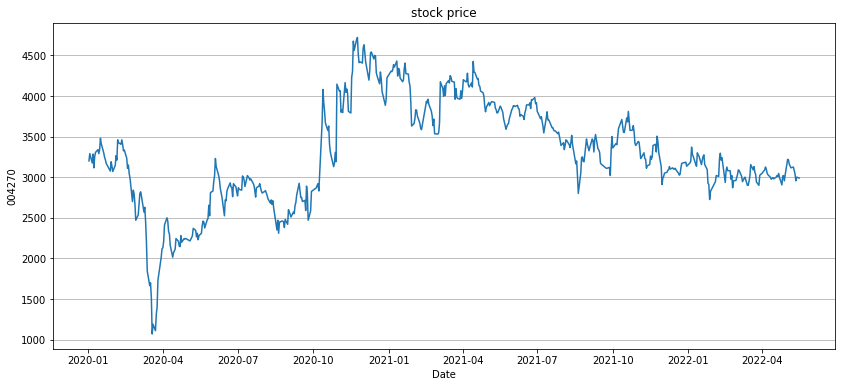

Negative
[주요] 
-中 실물 지표 예상치 하회
- 경기 침체 이슈 부각
[요약] 
코스피는 각종 경제 지표들의 발표로 인해 하락 전환해 2600선이 무너졌다.
[회사정보] 
null 

Negative
[주요] 
-코스피 7.66p 내린 2596.58
- 코스닥 3.17p 오른 856.25
[요약] 
16일 코스피는 코스피는 전날보다 7.66포인트 내린 2596.58에, 서울 외환시장은 원·달러 환율은 전 거래일보다 0.1원 하락한 1284.1원에 장 마감, 코스닥은 전 거래일(853.08)보다 3.17포인트(0.37%) 오른 856.25에 거래를 마쳤다.
[회사정보] 
null 

Negative
[주요] 
-코스피 7.66p 내린 2596.58
- 코스닥 3.17p 오른 856.25
[요약] 
16일 코스피는 코스피는 전날보다 7.66포인트 내린 2596.58에, 서울 외환시장은 원·달러 환율은 전 거래일보다 0.1원 하락한 1284.1원에 장 마감하고, 코스닥은 전날보다 3.17포인트(0.37%) 오른 856.25에 거래를 마쳤다.
[회사정보] 
null 

Positive
[주요] 
-스테이블코인 '기축통화' 역할
- 루나 사태, 시장 전체 위기로 번질수도
[요약] 
미국은 규제를 통해 스테이블코인의 위험성을 드러나게 해 가상자산 규제 강화를 더욱 앞당길 것으로 보인다.
[회사정보] 
null 

Negative
[주요] 
-1분기 영업익 30억원...전년比 116.7%↑
- 매출액·당기순이익 각각 127억원·21억원
[요약] 
미래산업이 반도체 검사 장비 '테스트핸들러'의 매출 호조에 힘입어 1분기 연결기준 영업이익이 30억원으로 전년동기대비 116.7% 증가해 2020년 1분기 실적 개선 이후 9분기 연속 흑자 경영을 이어가고 있다.
[회사정보] 
['미래산업', '025560', 'KOSPI']
               시가     고가     저가     종가     거래량
날짜                                

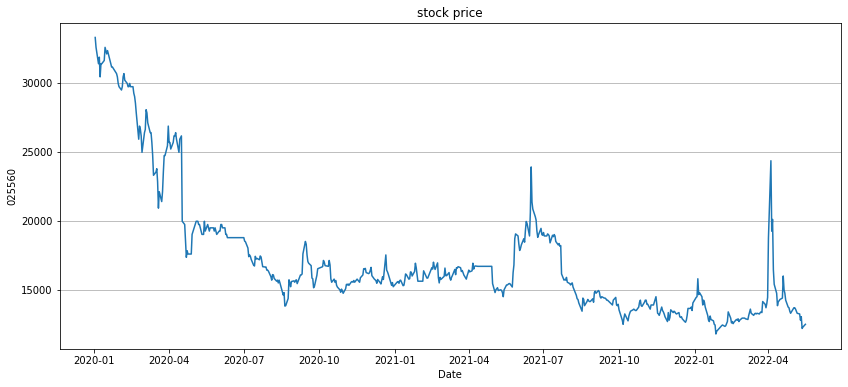

Negative
[주요] 
-추경호 부총리 조찬 회동 직후 취재진 만나
- "빅스텝 가능성 완전히 배제할 단계 아냐"
[요약] 
코스피 코스피가 중국의 경제 지표 악화와 한국은행의 기준금리 인상 시사 발언에 하락하면서 2020선을 다시 무너뜨렸고 코스닥도 상승폭을 반납하며 거래를 마쳤다.
[회사정보] 
null 

Negative
[주요] 
-전년 동기보다 50.8% 증가
- 대규모 특별퇴직 인건비 절감
[요약] 
SC제일은행은 올해 1분기 연결 기준 당기순이익이 1천551억원으로 전년 동기보다 50.8% 증가한 반면, 비용은 지난해 10월 실시한 특별퇴직의 영향이 올해부터 인건비 절감 효과로 나타나 전년 동기 보다 감소했다고 말했다.
[회사정보] 
null 

Negative
[주요] 
-시초가 대비 9.71% 내린 1만3950원에 마감
-  풍력, 태양광 등 신재생에너지 사업 개발 및 설계·조달·시공
[요약] 
신재생명에너지를 담당하는 대명에너지는 코스닥 상장 첫날인 16일 공모가보다 낮은 가격에 거래를 시작해 공모가(1만5000원)를 7% 하회하는 수준으로 마감했다.
[회사정보] 
null 

Negative
[주요] 
-코스피 2,596.58 마감
- 2거래일 만에 2,600선 하회
[요약] 
코스피가 약보합권에서 마감한 16일 오후 서울 중구 하나은행 딜링룸에서 직원들이 업무를 보고 있다.
[회사정보] 
null 

Positive
[주요] 
-브로커리지 수입 의존 않고 본업인 부동산 금융 집중
- 저축은행 효과도 누려
[요약] 
국내 증시 하락과 금리 상승으로 증권사들의 1분기 실적이 줄어든 가운데 다올투자증권이 위탁매매(브로커리지) 수입에 의존하지 않고 본업인 부동산 금융에 집중한 전략이 적중하여 사상 최대 실적을 기록했다고 밝혔다.
[회사정보] 
null 

Positive
[주요] 
-文대통령, 국무회의 모두발언
- "경제활력·민생·평화번영·경제강국"
[요약] 
6·1 지방선거의 최대 격전지로 꼽히는 경기지사 선거에서 김동연 더불어민주당 후보와

'\n# mount it\nfrom google.colab import drive\ndrive.mount(\'/content/drive\')\n# copy it there\n#!cp "20220408_summarized.txt" /content/drive/MyDrive\n!cp "20220516_url.txt" /content/drive/MyDrive\n'

In [28]:
import time
import re
import requests
from datetime import datetime
from dateutil.relativedelta import relativedelta

# 오늘 날짜 형식화
now=datetime.now()
now=str(now)
year=now[0:4]
month=now[5:7]
day=now[8:10]
res=year+month+day

# url file에 저장 (max_page_num 바꿔주면 됨)
output_file_name=str(res)+"_url.txt"
output_file = open(output_file_name, "w", encoding="utf-8")
page_num = 1
max_page_num = 10

user_agent = "'Mozilla/5.0"
headers ={"User-Agent" : user_agent}

urls = []
while page_num<=max_page_num:
    page_url = "http://news.naver.com/main/list.nhn?sid2=258&sid1=101&mid=shm&mode=LS2D&date=" + str(res) + "&page=" + str(page_num) + ""
    response = requests.get(page_url, headers=headers)
    html = response.text
    # url 추출
    url_frags = re.findall('<a href="(.*?)"',html)
    for url_frag in url_frags:
        if "article" in url_frag:
            urls.append(url_frag)
            #print(url_frag)
    page_num+=1
urls=set(urls)
for url in urls:
    print(url, file=output_file)
time.sleep(2)
output_file.close()

# url 바탕으로 요약문 생성
# 요약문 file에 저장(테스트용으로 count로 개수 끊어준것임)
output_file_name2=str(res)+"_summarized.txt"
output_file2 = open(output_file_name2, "w", encoding="utf-8")
count=0
for url in urls:
  if(count>20):
    break
  count=count+1
  print(summerize_news(url,return_name()), file=output_file2)
output_file2.close()

'''
# mount it
from google.colab import drive
drive.mount('/content/drive')
# copy it there
#!cp "20220408_summarized.txt" /content/drive/MyDrive
!cp "20220516_url.txt" /content/drive/MyDrive
'''


In [29]:
# mount it
from google.colab import drive
drive.mount('/content/drive')
# copy it there
#!cp "20220408_summarized.txt" /content/drive/MyDrive
!cp "20220516_url.txt" /content/drive/MyDrive

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Negative
[주요] 
-롯데케미칼 日지사 상무 합류
- 인수·합병 담당할 듯
[요약] 
롯데 황동빈 롯데그룹 회장의 장남 신유열씨가 최근 롯데케미칼 일본 지사에 상무로 합류했는데, 일본 롯데, 롯데홀딩스 업무도 겸직하면서 향후 인수·합병(M&A) 업무를 담당할 것으로 알려졌다.
[회사정보] 
['롯데케미칼', '011170', 'KOSPI']
                시가      고가      저가      종가     거래량
날짜                                                
2022-05-09  196000  196500  191000  192000   70139
2022-05-10  191000  191500  186000  189500  107593
2022-05-11  187000  192500  187000  191500   92096
2022-05-12  189500  192000  187000  188000  103716
2022-05-13  186500  192500  186500  192500   58307
2022-05-16  193000  194000  190000  192500   54645
                     시가총액     거래량         거래대금     상장주식수
날짜                                                      
2022-05-09  6580880448000   70139  13526781500  34275419
2022-05-10  6495191900500  107593  20434978000  34275419
2022-05-11  6563742738500   92096  17471031000  34275419
2022-05-12  6443778772000  103716  19579649000  34275419
2022-05-13  6598018157500   58307  11130666500  342754

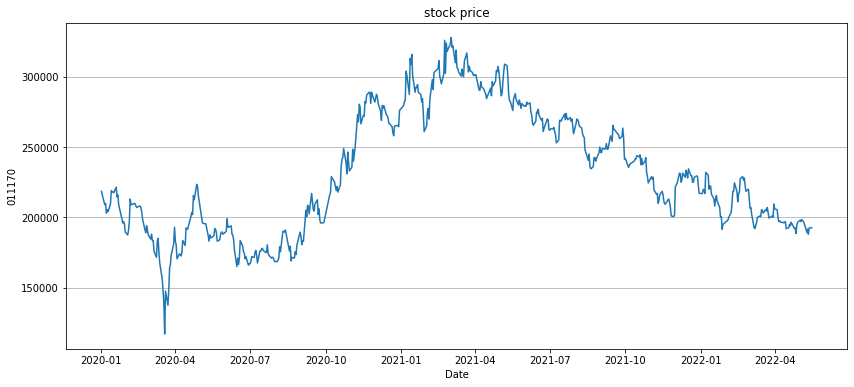

"[주요] \n-롯데케미칼 日지사 상무 합류\n- 인수·합병 담당할 듯\n[요약] \n롯데 황동빈 롯데그룹 회장의 장남 신유열씨가 최근 롯데케미칼 일본 지사에 상무로 합류했는데, 일본 롯데, 롯데홀딩스 업무도 겸직하면서 향후 인수·합병(M&A) 업무를 담당할 것으로 알려졌다.\n[회사정보] \n['롯데케미칼', '011170', 'KOSPI']"

In [14]:
summerize_news('https://n.news.naver.com/mnews/article/277/0005088162?sid=101', return_name())